<a href="https://colab.research.google.com/github/sksvineeth/Text_and_clustering/blob/main/Detailed_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Netflix Case Study**

Problem 1: Build Model(s)

· Group different movies using text and clustering algorithm.

## Libraries

In [ ]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import nltk
import re
import string
import itertools
#nltk.download('punkt')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from collections import Counter

## **Data Cleaning :**

In [ ]:
# Read data
np.random.seed(5)
data_first = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix_titles.csv')
data_first.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [ ]:
data_first.groupby('type').count() # Subset only movies
data_first = data_first.loc[(data_first["type"] != 'TV Show')]

In [ ]:
data_first.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
6,s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,"June 1, 2020",2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ..."


In [ ]:
def convert(text):
    parts = text.split(' ')
    value = float(parts[0])
    return value

data_first['duration'] = data_first['duration'].apply(convert)

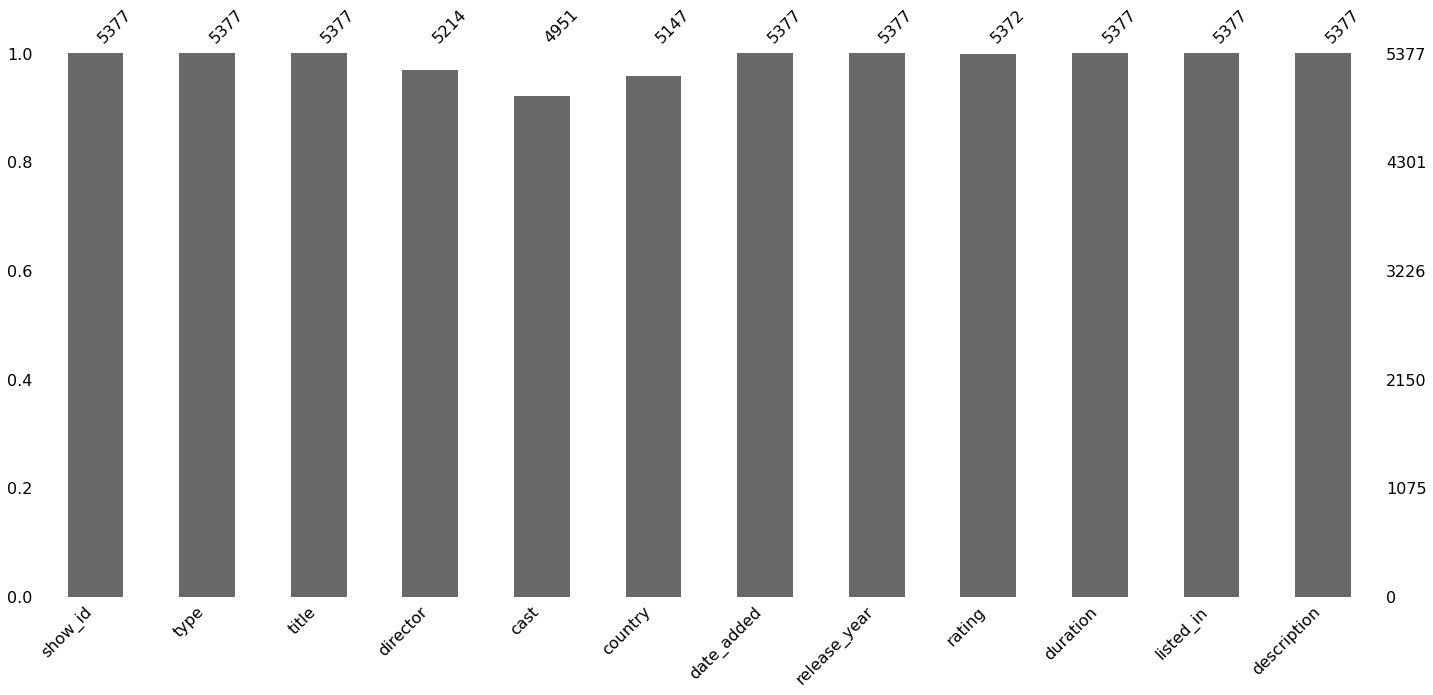

In [ ]:
# Data Features - Multiple values - liste_in, Cast
#                - Categories - Rating, director
#Let's visualize and clean the data
missingno.bar(data_first);

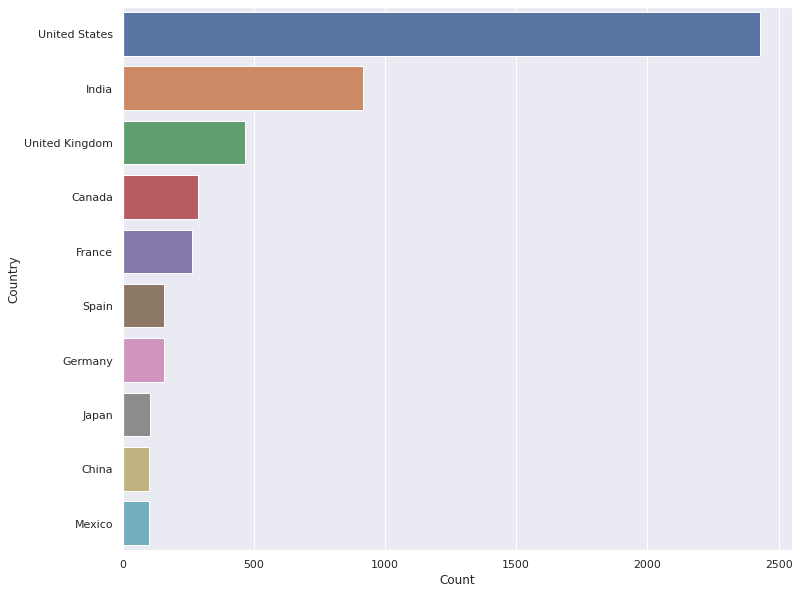

In [ ]:
# Lets visualize data to decide the features.


list_country = [x.split(', ') for x in data_first.dropna(subset=['country'])['country'].tolist()]
list_country = list(itertools.chain(*list_country))
df_netflix_country_count = pd.DataFrame(Counter(list_country).most_common()[:10], columns=['Country', 'Count'])

plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.barplot(y="Country", x='Count', data=df_netflix_country_count, orient='h')

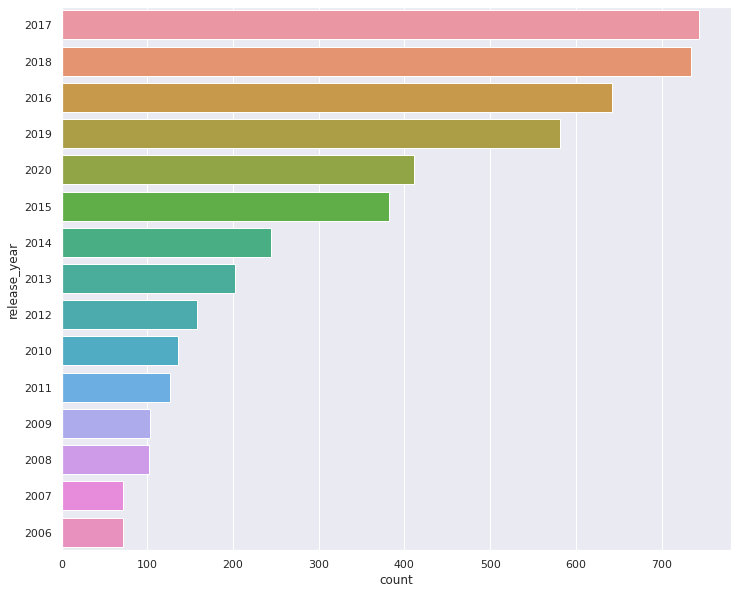

In [ ]:
#Year

plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y='release_year', data=data_first, order=data_first['release_year'].value_counts().index[0:15])

## EDA and Data Engineering

In [ ]:
# Cleaning and one hot encoding categorical variables

def clean(column_name):
    """This function takes a column from the dataframe and splits two elements
       if they are separated by a comma.
       For ex. in Actors column there might be values such as Christian Bale, Morgan Freeman.
       This will separate these two actors and store them individually in a list."""
    name=set()
    for name_string in data_first[column_name]:
        name.update(name_string.split(', '))
    name=sorted(name)
    return name

def top(column_name):
    """This function takes its input as name of the column and returns a sorted list of the 
       elements which occur very frequently in that column in descending order."""
    
    name=clean(column_name)
    dummy_name=pd.DataFrame()
    for n in name:
        dummy_name[n]=[int(n in nm.split(', ')) for nm in data_first[column_name]] 
    
    namelist=[n for n in name]
    nlt=dummy_name[namelist].sum()
    nlt=nlt.sort_values(axis=0,ascending=False)
    return nlt.index
    
def plot_column(column_name,n_elem_display=0):
    """ This function is used to plot a bar graph of a column of the dataframe.
        It takes its argument as name of column and number of elements to display and
        return a bar graph of the user defined number of top elements which occur
        frequently in that column."""
    
    name=clean(column_name)
    dummy_name=pd.DataFrame()
    for n in name:
        dummy_name[n]=[int(n in nm.split(', ')) for nm in data_first[column_name]] 
    
    namelist=[n for n in name]
    nlt=dummy_name[namelist].sum()
    nlt=nlt.sort_values(axis=0,ascending=False)
    if n_elem_display !=0:
        return nlt[:n_elem_display].plot(kind = "bar",figsize=(10,10))
    else:
        return nlt[:].plot(kind = "bar",figsize=(10,5))

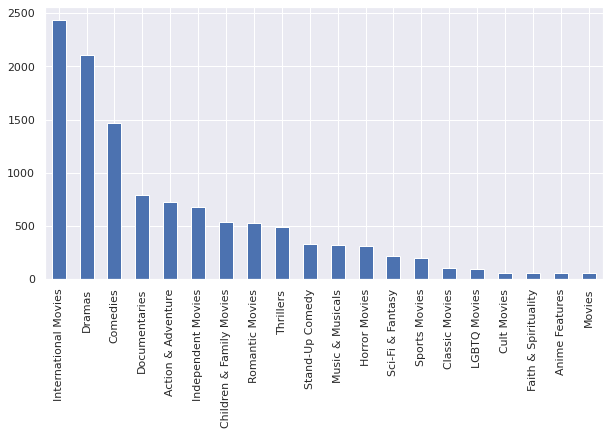

In [ ]:
plot_column('listed_in')
#Get the unique genres contained in the dataframe
genres= clean('listed_in')
#Add one column for every genre in the dataframe
for genre in genres:
    data_first["genre:"+genre] = [int(genre in g.split(', ')) for g in data_first.listed_in]

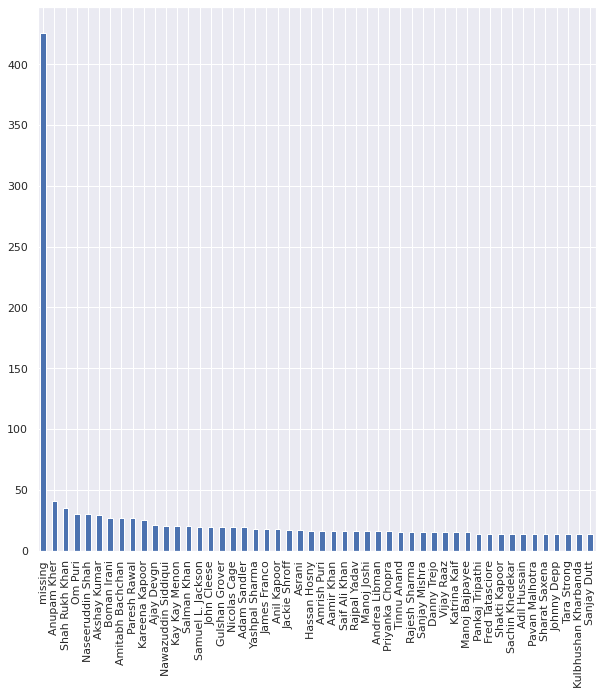

In [ ]:
data_first = data_first.fillna('missing')
plot_column('cast', 50)
#Get the unique actors contained in the dataframe
Actors= top('cast')
#Add one column for every actor in the dataframe
for Actor in Actors[:50]: #checked different ranges and fixed for 50
    data_first["Cast:"+ Actor] = [int(Actor in g.split(', ')) for g in data_first.cast]

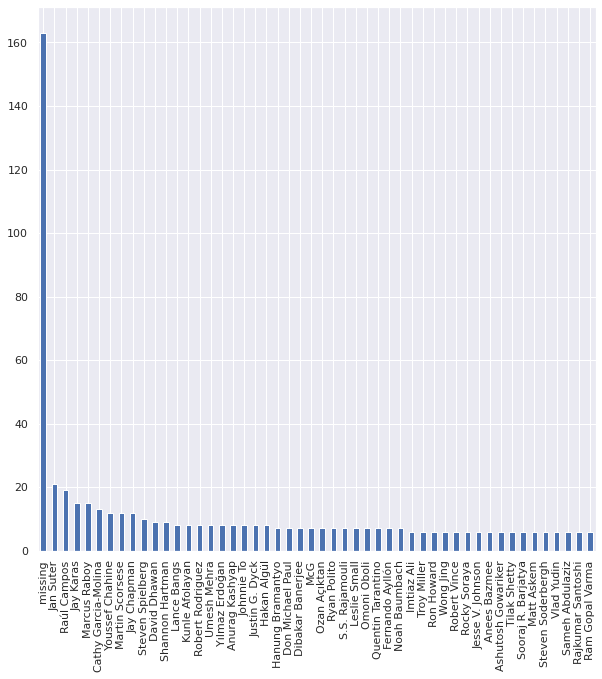

In [ ]:
plot_column('director', 50)
directors=top('director')
    
for director in directors[:50]:
    data_first["Director:"+director] = [int(director in d.split(', ')) for d in data_first.director]

In [ ]:
data_first.shape

(5377, 132)

### **Text processing**

In [ ]:
def my_analyzer(s):
# Synonym List
    syns = {'wont':'would not', 'cant':'can not', 'cannot':'can not', \
    'couldnt':'could not', 'shouldnt':'should not', \
    'wouldnt':'would not', 'straightforward': 'straight forward' }
    # Preprocess String s
    s = s.lower()
    #Replace special characters with spaces
    s = s.replace('-', ' ')
    s = s.replace('_', ' ')
    s = s.replace(',', '. ')
    s = s.replace('\\',"")
    s = s.replace('.',"")

    # Replace not contraction with not
    s = s.replace("'nt", " not")
    s = s.replace("n't", " not")

    # Tokenize
    tokens = word_tokenize(s)

    #tokens = [word.replace(',','') for word in tokens ]

    tokens = [word for word in tokens if ('*' not in word) and \
    ("''" != word) and ("``" != word) and \
    (word!='description') and (word !='dtype') \
    and (word != 'object') and (word!="'s")]

    # Map synonyms
    for i in range(len(tokens)):
        if tokens[i] in syns:
            tokens[i] = syns[tokens[i]]

    # Remove stop words
    punctuation = list(string.punctuation)+['..', '...']
    pronouns = ['i', 'he', 'she', 'it', 'him', 'they', 'we', 'us', 'them','he ']
    others = ["'d", "co", "ed", "put", "say", "get", "can", "become",\
            "los", "sta", "la", "use","ask" "iii", "else","doesn't","dr.","well","let","soon","finally","around","little",\
              "would","set","use","place","still","three","arrive","next","anoth","keep","must","mr.","bring",\
              "much","many","eventually","explain","asks","along","may","small","hold","realize","think","continue",\
             "last","behind","discover","something","several","end","large","high","mr","the","dr","mr"]
    names = ["harry","travis","tommy","joe","jack","dorothy","mike","george","frank","frankie",\
            "frank ","sarah","andrew","taylor","arthur","luke","kane","wallace","parker","danny","tony",\
            "michael","luke","kane","danny","john","max","tom","paul","ca","neil","maria","barry","anna","jerry",\
            "alex","terry","henry","gordon","leonard","wayne","vincent","jimmy","jordan","sam","nick","nicholson",\
            "jake","rocky"]

    stop = stopwords.words('english') + punctuation + pronouns + others + names
    filtered_terms = [word for word in tokens if (word not in stop) and \
    (len(word)>1) and (not word.replace('.','',1).isnumeric()) \
    and (not word.replace("'",'',2).isnumeric())]

    # Lemmatization & Stemming - Stemming with WordNet POS
    # Since lemmatization requires POS need to set POS
    tagged_words = pos_tag(filtered_terms, lang='eng')

    # Stemming with for terms without WordNet POS
    stemmer = SnowballStemmer("english")
    wn_tags = {'N':wn.NOUN, 'J':wn.ADJ, 'V':wn.VERB, 'R':wn.ADV}
    wnl = WordNetLemmatizer()
    stemmed_tokens = []
    for tagged_token in tagged_words:
        term = tagged_token[0]
        pos = tagged_token[1]
        pos = pos[0]
        try:
            pos = wn_tags[pos]
            stemmed_tokens.append(wnl.lemmatize(term, pos=pos))
        except:
            stemmed_tokens.append(stemmer.stem(term))
    return stemmed_tokens

In [ ]:
n_plots = len(data_first['description']) # Number of Plots
s_words = 'english' # Stop Word Dictionary
ngram = (1,3) # n-gram POS modeling
plots = data_first['description'].map(str) # place all text reviews in reviews
tfidf=True

In [ ]:
# Create Word Frequency by Review Matrix using Custom Analyzer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet as wn

cv = CountVectorizer(max_df=0.9, min_df=3, max_features=None ,\
analyzer=my_analyzer, ngram_range=ngram)
tf1 = cv.fit_transform(plots)
terms1 = cv.get_feature_names()
term_sums = tf1.sum(axis=0)
term_counts = []
out1 = []
out2 = []
for i in range(len(terms1)):
    term_counts.append([terms1[i], term_sums[0,i]])
def sortSecond(e):
    return e[1]
term_counts.sort(key=sortSecond, reverse=True)
print("\nTerms with Highest Frequency:")
for i in range(400):
    print('{:<15s}{:>5d}'.format(term_counts[i][0], term_counts[i][1]))
    out1.append([term_counts[i][0], term_counts[i][1]])
np.savetxt("frequency_100.csv", out1, delimiter=",", fmt='%s')
print("")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

Terms with Highest Frequency:
life             611
young            521
find             468
woman            434
man              413
new              411
family           408
take             394
love             358
friend           326
two              309
year             291
documentary      276
world            271
one              246
father           237
old              231
help             225
try              219
make             213
turn             203


In [ ]:
# if tfidf is requested, replace tf matrix with frequencies weighted by IDF
if tfidf == True:
    # Construct the TF/IDF matrix from the data
    print("Conducting Term/Frequency Matrix using TF-IDF")
    tfidf_vect = TfidfVectorizer(max_df=0.7, min_df=5, \
    max_features=None,\
    analyzer=my_analyzer, ngram_range=ngram)
    tf = tfidf_vect.fit_transform(plots)
    terms = tfidf_vect.get_feature_names()
    term_idf_sums = tf.sum(axis=0)
    term_idf_scores = []
    for i in range(len(terms)):
        term_idf_scores.append([terms[i], term_idf_sums[0,i]])
    print("The Term/Frequency matrix has", tf.shape[0], " rows, and",\
        tf.shape[1], " columns.")
    print("The Term list has", len(terms), " terms.")
    term_idf_scores.sort(key=sortSecond, reverse=True)
    print("\nTerms with Highest TF-IDF Scores:")
    for i in range(100):
        print('{:<15s}{:>8.2f}'.format(term_idf_scores[i][0], \
        term_idf_scores[i][1]))
        out2.append([term_idf_scores[i][0], term_idf_scores[i][1]])
        np.savetxt("tfidf1_100.csv", out2, delimiter=",", fmt='%s')

Conducting Term/Frequency Matrix using TF-IDF
The Term/Frequency matrix has 5377  rows, and 2855  columns.
The Term list has 2855  terms.

Terms with Highest TF-IDF Scores:
life             101.04
young             89.69
find              83.46
woman             80.13
man               76.26
family            75.28
new               75.08
take              73.25
love              69.53
friend            64.70
two               59.85
year              58.54
documentary       57.01
world             55.00
one               51.41
father            50.98
old               48.78
help              47.13
try               46.40
make              45.65
turn              43.71
home              43.52
fall              43.12
story             42.01
girl              41.98
live              40.94
school            40.67
go                39.76
son               39.06
struggle          37.55
save              37.02
mother            36.91
force             36.45
murder            36.21
special    

In [ ]:
## Creating a dataframe of all frequent words from count_vectorizer
k = tf1.todense()
freq = pd.DataFrame(k,columns = terms1)
freq_words = freq.sum(axis = 0)
freq = freq.append(freq_words,ignore_index = True)


## Transposing and rearranging
freq.t = freq.T
freq.t = freq.t.reset_index()
freq.t = freq.t.drop(['index'],axis = 1)
freq.t.index = terms1
freq.t.columns.values[5377] = "freq_sum"
freq.t = freq.t.sort_values("freq_sum",ascending = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [ ]:
top_words = []
for i in range(100):
    top_words.append(out2[i][0])

In [ ]:
top_words

['life',
 'young',
 'find',
 'woman',
 'man',
 'family',
 'new',
 'take',
 'love',
 'friend',
 'two',
 'year',
 'documentary',
 'world',
 'one',
 'father',
 'old',
 'help',
 'try',
 'make',
 'turn',
 'home',
 'fall',
 'story',
 'girl',
 'live',
 'school',
 'go',
 'son',
 'struggle',
 'save',
 'mother',
 'force',
 'murder',
 'special',
 'daughter',
 'follow',
 'get',
 'meet',
 'teen',
 'stand',
 'brother',
 'wife',
 'secret',
 'face',
 'film',
 'return',
 'group',
 'star',
 'student',
 'team',
 'death',
 'begin',
 'work',
 'boy',
 'come',
 'town',
 'leave',
 'way',
 'back',
 'child',
 'time',
 'become',
 'couple',
 'city',
 'day',
 'war',
 'fight',
 'learn',
 'past',
 'relationship',
 'plan',
 'lead',
 'show',
 'comedy',
 'move',
 'comedian',
 'battle',
 'four',
 'true',
 'run',
 'look',
 'search',
 'first',
 'seek',
 'cop',
 'dream',
 'change',
 'best',
 'big',
 'former',
 'crime',
 'career',
 'marriage',
 'journey',
 'marry',
 'sister',
 'travel',
 'win',
 'american']

In [ ]:
words_df = freq.t.T
df = words_df[top_words]

df_encoded = df
df_encoded[df_encoded!=0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [ ]:
data_first = data_first.reset_index(drop=True)
df_encoded = df_encoded.reset_index(drop=True)
df_final2 = pd.concat([data_first, df_encoded], axis=1)
df_final2 = df_final2.drop(['show_id','date_added','director','cast','description','rating',\
                          'country','type','listed_in'],axis = 1)
df_final2 = df_final2[:-1]

In [ ]:
df_final2

,title,release_year,duration,genre:Action & Adventure,genre:Anime Features,genre:Children & Family Movies,genre:Classic Movies,genre:Comedies,genre:Cult Movies,genre:Documentaries,genre:Dramas,genre:Faith & Spirituality,genre:Horror Movies,genre:Independent Movies,genre:International Movies,genre:LGBTQ Movies,genre:Movies,genre:Music & Musicals,genre:Romantic Movies,genre:Sci-Fi & Fantasy,genre:Sports Movies,genre:Stand-Up Comedy,genre:Thrillers,Cast:missing,Cast:Anupam Kher,Cast:Shah Rukh Khan,Cast:Om Puri,Cast:Naseeruddin Shah,Cast:Akshay Kumar,Cast:Boman Irani,Cast:Amitabh Bachchan,Cast:Paresh Rawal,Cast:Kareena Kapoor,Cast:Ajay Devgn,Cast:Nawazuddin Siddiqui,Cast:Kay Kay Menon,Cast:Salman Khan,Cast:Samuel L. Jackson,Cast:John Cleese,Cast:Gulshan Grover,...,child,time,become,couple,city,day,war,fight,learn,past,relationship,plan,lead,show,comedy,move,comedian,battle,four,true,run,look,search,first,seek,cop,dream,change,best,big,former,crime,career,marriage,journey,marry,sister,travel,win,american
0,7:19,2016.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,23:59,2011.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,2009.0,80.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,21,2008.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,122,2019.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5372,Zoom,2006.0,88.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5373,Zozo,2005.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5374,Zubaan,2015.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5375,Zulu Man in Japan,2019.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Feature Engineering - Topic Modelling**


In [ ]:
# Remove punctuation
movies = df
data_first['description_processed'] = data_first['description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
data_first['description_processed'] = data_first['description'].map(lambda x: x.lower())


In [ ]:
#tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = data_first.description_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])
len(data_words)

['after', 'devastating', 'earthquake', 'hits', 'mexico', 'city', 'trapped', 'survivors', 'from', 'all', 'walks', 'of', 'life', 'wait', 'to', 'be', 'rescued', 'while', 'trying', 'desperately', 'to', 'stay', 'alive']


5377

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# NLTK Stop words - Remove Stopwords, Make Bigrams and Lemmatize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['devastate', 'earthquake', 'hit', 'trap', 'survivor', 'walk', 'life', 'wait', 'rescue', 'try', 'desperately', 'stay', 'alive']]


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


##**Topic** Modelling

### Base Model

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=15, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
base_score = coherence_lda


Coherence Score:  0.3505838403592611


### **Tuning**

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha= 'asymmetric',
                                           )

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
Final_model = coherence_lda
Improvement = ((Final_model) - (base_score))/ (base_score)
Improvement


Coherence Score:  0.5750023362567497


0.6401278954201527

In [ ]:
# Verify topic words

from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"life" + 0.013*"take" + 0.012*"young" + 0.011*"find" + '
  '0.010*"documentary" + 0.009*"woman" + 0.008*"family" + 0.008*"new" + '
  '0.008*"world" + 0.007*"friend"'),
 (1,
  '0.013*"must" + 0.011*"family" + 0.010*"man" + 0.009*"young" + 0.009*"woman" '
  '+ 0.008*"love" + 0.008*"big" + 0.007*"dream" + 0.007*"special" + '
  '0.007*"life"'),
 (2,
  '0.020*"team" + 0.010*"reveal" + 0.009*"partner" + 0.009*"local" + '
  '0.007*"lead" + 0.007*"become" + 0.007*"send" + 0.007*"documentary" + '
  '0.006*"tell" + 0.006*"pay"'),
 (3,
  '0.013*"create" + 0.012*"reality" + 0.010*"town" + 0.009*"plot" + '
  '0.009*"pal" + 0.009*"train" + 0.008*"small" + 0.008*"monster" + '
  '0.008*"street" + 0.007*"leave"'),
 (4,
  '0.019*"love" + 0.018*"young" + 0.016*"friend" + 0.015*"get" + 0.015*"woman" '
  '+ 0.014*"family" + 0.013*"find" + 0.012*"man" + 0.011*"new" + 0.011*"boy"'),
 (5,
  '0.010*"identity" + 0.010*"must" + 0.009*"agent" + 0.008*"officer" + '
  '0.008*"terrorist" + 0.007*"save"

### **LDA** Model Analysis

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

### Reframing Topic features to dataframe

In [ ]:
document_key = list(df_final2.index) ##get index of transcripts for topic in each
document_topic = {}
for doc_id in range(len(corpus)):
    docbok = corpus[doc_id]
    doc_topics = lda_model.get_document_topics(docbok, 0)
    tmp = []
    for topic_id, topic_prob in doc_topics:
        tmp.append(topic_prob)
    document_topic[document_key[doc_id]] = tmp
# convert dictionnary of document-topic distritbutions to dataframe
df = pd.DataFrame.from_dict(document_topic, orient='index')
topic_column_names = ['topic_' + str(i) for i in range(0, 10)]
df.columns = topic_column_names
df['description'] = (data_first['description']) # reset index

df.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,description
0,0.369429,0.011110,0.008906,0.007459,0.006418,0.078757,0.505500,0.004523,0.004118,0.003779,After a devastating earthquake hits Mexico Cit...
1,0.654293,0.014069,0.157822,0.009494,0.008169,0.007167,0.133179,0.005757,0.005241,0.004810,"When an army recruit is found dead, his fellow..."
2,0.018583,0.014126,0.011332,0.009494,0.008168,0.916104,0.006385,0.005757,0.005241,0.004810,"In a postapocalyptic world, rag-doll robots hi..."
3,0.168055,0.011124,0.008921,0.007460,0.006418,0.005631,0.005017,0.004523,0.779071,0.003779,A brilliant group of students become card-coun...
4,0.016306,0.011993,0.009598,0.364842,0.367594,0.006065,0.210227,0.004871,0.004435,0.004070,"After an awful accident, a couple admitted to ..."


In [ ]:
def find_topic(row):
    if (row.loc[row>0.3]).any():
        return row.loc[row>0.3].index[0]
    else:
        return None
    
def find_propensity(row):
    if (row.loc[row>0.3]).any():
        return row.loc[row>0.3].values[0]
    else:
        return None
    
df['topic'] = df.loc[:, df.columns !='description'].apply(find_topic, axis = 1)
df['propensity'] = df.iloc[:, 0:10].apply(find_propensity, axis = 1)

In [ ]:
#df.head()
df.drop(columns=df.columns[:10], inplace=True)

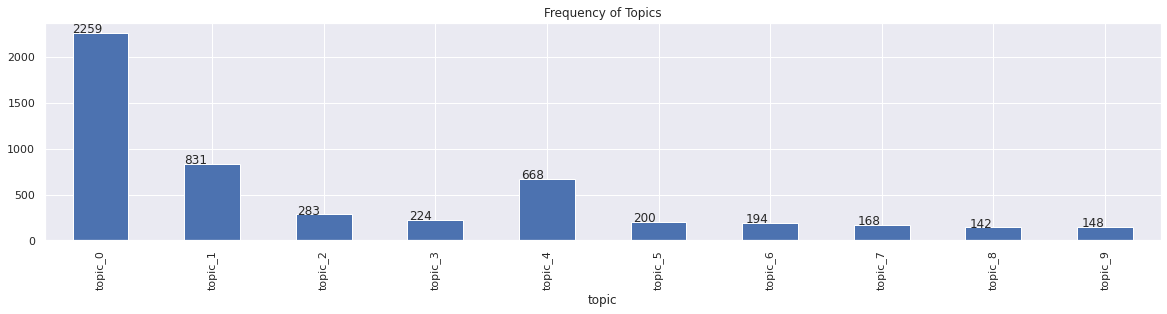

In [ ]:
# Visualizing the single topic per description for understanding

plt.rcParams["figure.figsize"] = (20,4)

topic_frequency = df.iloc[:, :2].groupby('topic').count()
ax = topic_frequency.plot.bar( legend=False)
plt.title("Frequency of Topics", size=12)
# plt.xticks(rotation=45)
ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)


for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

In [ ]:
topics_all = pd.DataFrame.from_dict(document_topic, orient='index')
topic_column_names = ['topic_' + str(i) for i in range(0, 10)]
topics_all.columns = topic_column_names
#topics_all.to_csv(os.path.join(BASE_PATH, "topic_propensities.csv"))

# print(topics_all.describe())
display(topics_all.head())

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.369429,0.011110,0.008906,0.007459,0.006418,0.078757,0.505500,0.004523,0.004118,0.003779
1,0.654293,0.014069,0.157822,0.009494,0.008169,0.007167,0.133179,0.005757,0.005241,0.004810
2,0.018583,0.014126,0.011332,0.009494,0.008168,0.916104,0.006385,0.005757,0.005241,0.004810
3,0.168055,0.011124,0.008921,0.007460,0.006418,0.005631,0.005017,0.004523,0.779071,0.003779
4,0.016306,0.011993,0.009598,0.364842,0.367594,0.006065,0.210227,0.004871,0.004435,0.004070


In [ ]:
data_c = pd.concat([df_final2, topics_all], axis=1)
data_c.head()

,title,release_year,duration,genre:Action & Adventure,genre:Anime Features,genre:Children & Family Movies,genre:Classic Movies,genre:Comedies,genre:Cult Movies,genre:Documentaries,genre:Dramas,genre:Faith & Spirituality,genre:Horror Movies,genre:Independent Movies,genre:International Movies,genre:LGBTQ Movies,genre:Movies,genre:Music & Musicals,genre:Romantic Movies,genre:Sci-Fi & Fantasy,genre:Sports Movies,genre:Stand-Up Comedy,genre:Thrillers,Cast:missing,Cast:Anupam Kher,Cast:Shah Rukh Khan,Cast:Om Puri,Cast:Naseeruddin Shah,Cast:Akshay Kumar,Cast:Boman Irani,Cast:Amitabh Bachchan,Cast:Paresh Rawal,Cast:Kareena Kapoor,Cast:Ajay Devgn,Cast:Nawazuddin Siddiqui,Cast:Kay Kay Menon,Cast:Salman Khan,Cast:Samuel L. Jackson,Cast:John Cleese,Cast:Gulshan Grover,...,relationship,plan,lead,show,comedy,move,comedian,battle,four,true,run,look,search,first,seek,cop,dream,change,best,big,former,crime,career,marriage,journey,marry,sister,travel,win,american,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,7:19,2016.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.369429,0.011110,0.008906,0.007459,0.006418,0.078757,0.505500,0.004523,0.004118,0.003779
1,23:59,2011.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.654293,0.014069,0.157822,0.009494,0.008169,0.007167,0.133179,0.005757,0.005241,0.004810
2,9,2009.0,80.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.018583,0.014126,0.011332,0.009494,0.008168,0.916104,0.006385,0.005757,0.005241,0.004810
3,21,2008.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.168055,0.011124,0.008921,0.007460,0.006418,0.005631,0.005017,0.004523,0.779071,0.003779
4,122,2019.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.016306,0.011993,0.009598,0.364842,0.367594,0.006065,0.210227,0.004871,0.004435,0.004070


In [ ]:
df_matrix = data_c.drop(['Cast:missing'\
                          ],axis = 1)

In [ ]:
data_c.shape

(5377, 233)

In [ ]:
dat = data_c.drop('title',axis=1)

In [ ]:
df_matrix = df_matrix.drop('title',axis=1).to_numpy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_matrix)
df_matrix=scaler.transform(df_matrix)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_matrix)
top_PCA=["%.2f" % a for a in pca.explained_variance_ratio_ if a >=0.001]
print(len(top_PCA))
print(top_PCA)
sumall=sum(pca.explained_variance_ratio_)

pca39 = PCA(n_components=len(top_PCA)).fit(df_matrix)
sum39=sum(pca39.explained_variance_ratio_)
print (sum39/sumall)

228
['0.02', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.

In [ ]:
first_comp = pca39.components_[1]
first_comps = pd.DataFrame(list(zip(first_comp, df_final2.columns)), columns=['weights', 'features'])
first_comps['abs_weights']=first_comps['weights'].apply(lambda x: np.abs(x))
first_comps.sort_values('abs_weights', ascending=False,inplace=True)

Top_39_features=first_comps
Top_39_features

,weights,features,abs_weights
20,0.378580,genre:Sports Movies,0.378580
161,0.296913,meet,0.296913
197,0.243613,comedy,0.243613
155,0.237860,force,0.237860
72,0.235435,Cast:Sanjay Dutt,0.235435
...,...,...,...
100,-0.001128,Director:S.S. Rajamouli,0.001128
148,-0.000855,live,0.000855
91,0.000571,Director:Johnnie To,0.000571
212,0.000476,big,0.000476


## K MEANS

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics
Xpca=pca39.transform(df_matrix)
km=KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1)
km_model=km.fit(Xpca)
kmeanlabels=km.labels_
kmeanclusters = km.predict(Xpca)
kmeandistances = km.transform(Xpca)

In [ ]:
films_kmeans = { 'title': list(data_c.title), 'rank': np.arange(0,len(data_c),1),'cluster': kmeanlabels}

frame_kmeans = pd.DataFrame(films_kmeans, index = [kmeanlabels] , columns = ['rank', 'title', 'cluster'])

frame_kmeans['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

3    4743
1     254
0     233
2     147
Name: cluster, dtype: int64

In [ ]:
base = metrics.silhouette_score(dat, kmeanlabels)
base

-0.1197115401395455

### Tuning

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

#scaler = StandardScaler().fit(data_c)
#df_matrix=scaler.transform()

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(Xpca)
    kmeanModel.fit(Xpca)
 
    distortions.append(sum(np.min(cdist(Xpca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data_c.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(Xpca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / data_c.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 1241182.3809859643
2 : 1227238.7957145798
3 : 1217868.690067133
4 : 1213077.7632675557
5 : 1199525.6645380713
6 : 1191591.329078899
7 : 1186895.240362319
8 : 1179965.3399443664
9 : 1176031.07759406
10 : 1166704.055111026
11 : 1164070.3093521534
12 : 1155741.4623319213
13 : 1154757.4152001408
14 : 1147422.6649847482
15 : 1142769.0238199763
16 : 1140841.823242063
17 : 1129202.7501537092
18 : 1123377.0687740895
19 : 1116973.7363660776


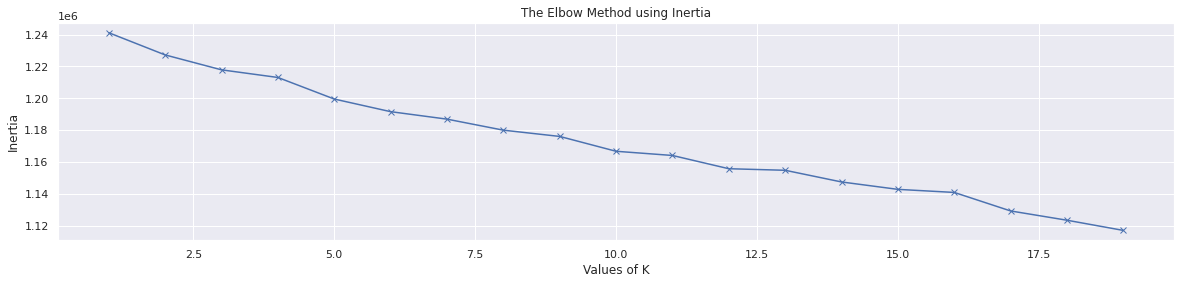

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Optimal number of clusters based on silhouette score: [25]


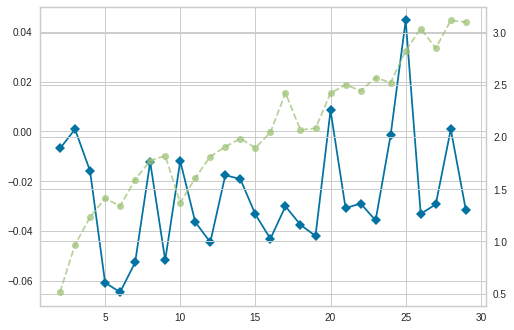

In [ ]:
# Silhouette Score for Kmeans

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), metric='silhouette', timings= True, locate_elbow=False)
visualizer.fit(Xpca)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure

df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on silhouette score:', df4['centers'].tolist())

As the data is sparse, Kmeans is not a good choice for clustering.

## Hiearchial Clustering

### **Base Model**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as metrics

model = AgglomerativeClustering(n_clusters=11, linkage = 'ward', affinity= 'euclidean' )
cluster = model.fit_predict(dat).tolist()
#dat["cluster"] = cluster

In [ ]:
base_score = metrics.silhouette_score(dat, model.labels_)
base_score

0.35968974841536994

### **Tuning**

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_clusters = 2
max_clusters = 20
step_size = 1
clusters_range = range(min_clusters, max_clusters, step_size)
# Alpha parameter
linkage = ['ward', 'complete', 'average', 'single']
# Validation sets
model_results = {
                 'clusters': [],
                 'Linkage': [],
                 'sil': []

                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=200)
    
    # iterate through validation corpuses
    for k in clusters_range:
            # iterate through alpha values
        for a in linkage:
                # get the coherence score for the given parameters
                model = AgglomerativeClustering(n_clusters= k, linkage = a)
                as_avg = model.fit_predict(data_c)
                #db  = davies_bouldin_score(data_c, model)
                sil = metrics.silhouette_score(data_c, model.labels_)
                # Save the model results
                model_results['clusters'].append(k)
                model_results['Linkage'].append(a)
                model_results['sil'].append(sil)
                #model_results['AG'].append(db)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('AG_tuning_results.csv', index=False)
    pbar.close()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz

Optimal number of clusters based on calinski_harabaz: [4]


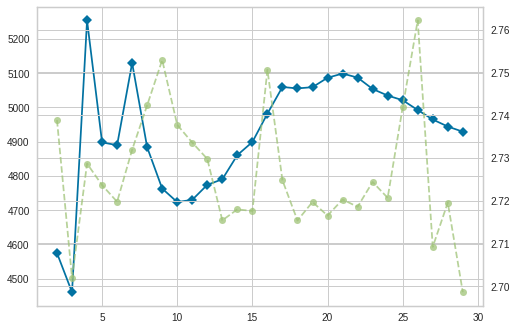

In [ ]:
# Calinski Harabasz Score for Hierarchical Clustering

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric= 'calinski_harabaz', timings= True, locate_elbow=False)
visualizer.fit(dat)        # Fit the data to the visualizer
#visualizer.show()            # Finalize and render the figure

df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on calinski_harabaz:', df4['centers'].tolist())

Optimal number of clusters based on silhouette score: [2]


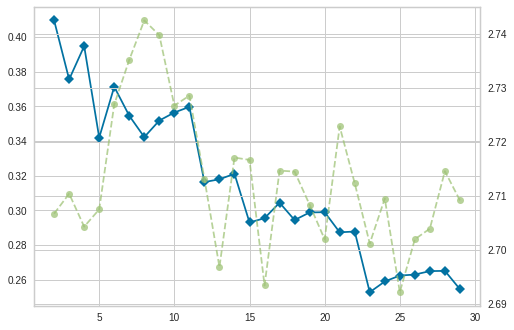

In [ ]:
# Silhouette Score for Hierarchical Clustering

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), metric='silhouette', timings= True, locate_elbow=False)
visualizer.fit(dat)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure

df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on silhouette score:', df4['centers'].tolist())

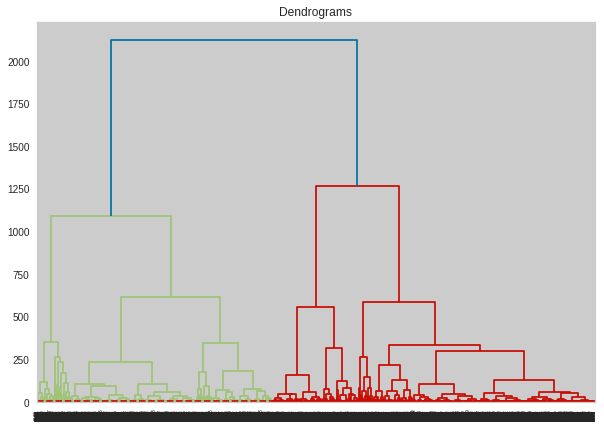

In [ ]:
from scipy.cluster import hierarchy
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = hierarchy.dendrogram(hierarchy.linkage(dat, method='ward'))
plt.axhline(y=9, color='r', linestyle='--')

### Final model

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as metrics
cluster_model = AgglomerativeClustering(n_clusters=4, linkage = 'ward', affinity= 'euclidean')  
cluster = cluster_model.fit_predict(dat).tolist()
dat["cluster"] = cluster

In [ ]:
Final_model = metrics.silhouette_score(dat, cluster_model.labels_)
Improvement = ((Final_model) - (base_score))/ (base_score)
Improvement

0.10031565663346854

## **Cluster Analysis** - Overview 

In [ ]:
df_for_h_visual = df
df_for_h_visual["cluster"] = dat["cluster"]
#df_for_h_visual.drop(['propensity'], axis = 1, inplace=True)
df_for_h_visual.topic.fillna(value="Unknown", inplace=True)
df_for_h_visual.head()

,description,topic,propensity,cluster
0,After a devastating earthquake hits Mexico Cit...,topic_0,0.369429,1
1,"When an army recruit is found dead, his fellow...",topic_0,0.654293,1
2,"In a postapocalyptic world, rag-doll robots hi...",topic_5,0.916104,1
3,A brilliant group of students become card-coun...,topic_8,0.779071,0
4,"After an awful accident, a couple admitted to ...",topic_3,0.364842,1


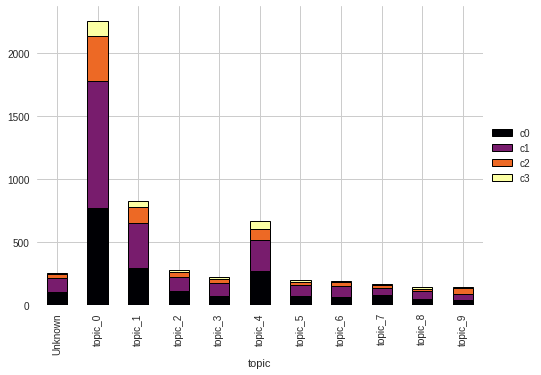

In [ ]:
df_histo = df_for_h_visual.groupby(['topic','cluster']).count().reset_index()
df_histo = df_histo.pivot(index='topic', columns='cluster', values='description')
df_histo.columns = ["c0", "c1", "c2", "c3"]

ax = df_histo.plot.bar(stacked=True,   colormap='inferno', edgecolor='black', linewidth=1)

ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

In [ ]:
df_for_h_visual.groupby('cluster').count()

,description,topic,propensity
cluster,,,
0,1946,1946,1840
1,2268,2268,2156
2,830,830,798
3,333,333,323


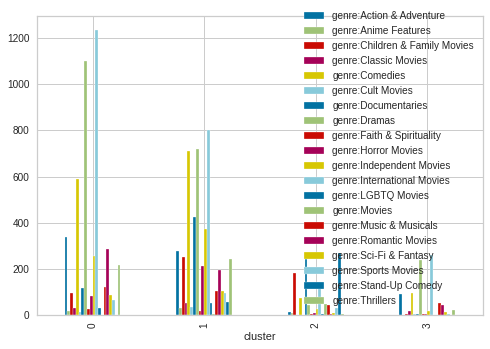

In [ ]:
data_c = dat
data_c.head()
cols = [
'genre:Action & Adventure',
'genre:Anime Features',	
'genre:Children & Family Movies',	
'genre:Classic Movies',	
'genre:Comedies',	
'genre:Cult Movies',	
'genre:Documentaries',	
'genre:Dramas',	
'genre:Faith & Spirituality',	
'genre:Horror Movies',	
'genre:Independent Movies',	
'genre:International Movies',	
'genre:LGBTQ Movies',	
'genre:Movies',	
'genre:Music & Musicals',	
'genre:Romantic Movies',	
'genre:Sci-Fi & Fantasy',
'genre:Sports Movies',
'genre:Stand-Up Comedy',	
'genre:Thrillers',]

import pandas as pd
import matplotlib.pyplot as plt

df1 = data_c.groupby('cluster')[cols].sum().reset_index()
df1.plot(x="cluster", y= cols, kind="bar")

In [ ]:
df_for_h_visual['title']= data_first['title']
documentaries_standup_comedies = df_for_h_visual.loc[df_for_h_visual['cluster'] == 2]
thriller_horror = df_for_h_visual.loc[df_for_h_visual['cluster'] == 3]
College_Friends = df_for_h_visual.loc[df_for_h_visual['cluster'] == 1]
#kids_animie_drama = df_for_h_visual.loc[df_for_h_visual['cluster'] == 4]# final
Crime_survive_thriller= df_for_h_visual.loc[df_for_h_visual['cluster'] == 0]

In [ ]:
documentaries_standup_comedies

,description,topic,propensity,cluster,title
27,This documentary celebrates the 50th anniversa...,topic_0,0.548829,2,#Rucker50
43,"Led by seventh-grader C.J., three students who...",topic_0,0.589852,2,100 Things to do Before High School
44,This documentary chronicles Elouise Cobell's l...,topic_0,0.933613,2,100 Years: One Woman's Fight for Justice
51,Oprah Winfrey sits down with director Ava DuVe...,topic_1,0.831418,2,13TH: A Conversation with Oprah Winfrey & Ava ...
73,Explore the circumstances surrounding the trag...,topic_1,0.651866,2,27: Gone Too Soon
...,...,...,...,...,...
5332,"""Saturday Night Live Korea"" writer-turned-come...",topic_0,0.574909,2,Yoo Byung Jae: Too Much Information
5348,Revisiting life goals set in a letter written ...,topic_1,0.558654,2,"Yours Sincerely, Kanan Gill"
5354,"The unorthodox, piano-playing stand-up star Za...",topic_0,0.376198,2,Zach Galifianakis: Live at the Purple Onion
5365,Born without legs and stuck in foster care for...,topic_4,0.428496,2,Zion


# **Problem 2:**

Use the clusters as labels to build a classification model (either Deep learning or Sequence models).

Developing a baseline classification model as a outline and the main approach is lited in the presentation


In [ ]:
# import libraries here; add more as necessary
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
text = data_first['description_processed']
label = dat["cluster"]
data_tuples = list(zip(label,text))
d = pd.DataFrame(data_tuples, columns=['cluster','text'])

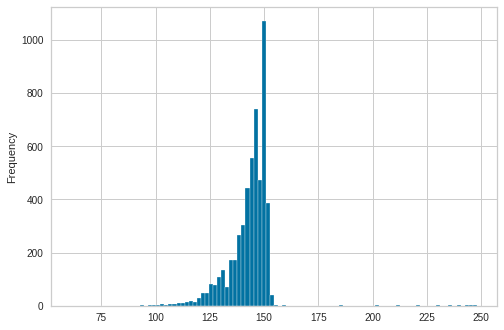

In [ ]:
# remove NULL Values from data
d_CNN = d[pd.notnull(d['cluster'])]
d_CNN['length'] = d_CNN['text'].apply(lambda s : len(s))
d_CNN['length'].plot.hist(bins=100)

In [ ]:
d_CNN.length.quantile(0.9)

150.0

In [ ]:
count_df = d_CNN[['cluster','text']].groupby('cluster').aggregate({'text':'count'}).reset_index().sort_values('text',ascending=False)
count_df.head()

,cluster,text
1,1,2268
0,0,1946
2,2,830
3,3,333


Need to research more on working on text imbalanced data!! For now I am going ahead with the base model

In [ ]:
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)


# lower the text
d_CNN["text"] = d_CNN["text"].apply(lambda x: x.lower())
# Clean the text
d_CNN["text"] = d_CNN["text"].apply(lambda x: clean_text(x))
# Clean numbers
d_CNN["text"] = d_CNN["text"].apply(lambda x: clean_numbers(x))
# Clean Contractions
d_CNN["text"] = d_CNN["text"].apply(lambda x: replace_contractions(x))

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_Y = train_test_split(d_CNN['text'], d_CNN['cluster'],
                                                    stratify=d_CNN['cluster'], 
                                                    test_size=0.20)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                    stratify=train_y, 
                                                    test_size=0.25)

In [ ]:
print("Train shape : ",train_X.shape)
print("Val shape : ",val_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3225,)
Val shape :  (1076,)
Test shape :  (1076,)


In [ ]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 150 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 10 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
val_y = le.transform(val_y.values)

In [ ]:
le.classes_

array([0, 1, 2, 3])

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-06-18 05:58:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-18 05:58:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-18 05:58:04--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = '/content/glove.6B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [ ]:
n_epochs = 15
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(val_X, dtype=torch.long).cuda()
y_cv = torch.tensor(val_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==val_y)/len(val_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/15 	 loss=587.7236 	 val_loss=427.2057  	 val_acc=0.4229  	 time=0.40s
Epoch 2/15 	 loss=537.5202 	 val_loss=412.7997  	 val_acc=0.4610  	 time=0.28s
Epoch 3/15 	 loss=510.9058 	 val_loss=399.6219  	 val_acc=0.4665  	 time=0.28s
Epoch 4/15 	 loss=493.2115 	 val_loss=390.3611  	 val_acc=0.4879  	 time=0.28s
Epoch 5/15 	 loss=470.8564 	 val_loss=384.9521  	 val_acc=0.4796  	 time=0.28s
Epoch 6/15 	 loss=453.7883 	 val_loss=376.7063  	 val_acc=0.5325  	 time=0.28s
Epoch 7/15 	 loss=433.1781 	 val_loss=372.4386  	 val_acc=0.5242  	 time=0.28s
Epoch 8/15 	 loss=415.6431 	 val_loss=368.6937  	 val_acc=0.5223  	 time=0.28s
Epoch 9/15 	 loss=397.9546 	 val_loss=366.9446  	 val_acc=0.5316  	 time=0.28s
Epoch 10/15 	 loss=376.0191 	 val_loss=365.9768  	 val_acc=0.5307  	 time=0.28s
Epoch 11/15 	 loss=356.3093 	 val_loss=363.6706  	 val_acc=0.5307  	 time=0.28s
Epoch 12/15 	 loss=334.5330 	 val_loss=362.9812  	 val_acc=0.5455  	 time=0.28s
Epoch 13/15 	 loss=314.2188 	 val_loss=362.3838  

In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

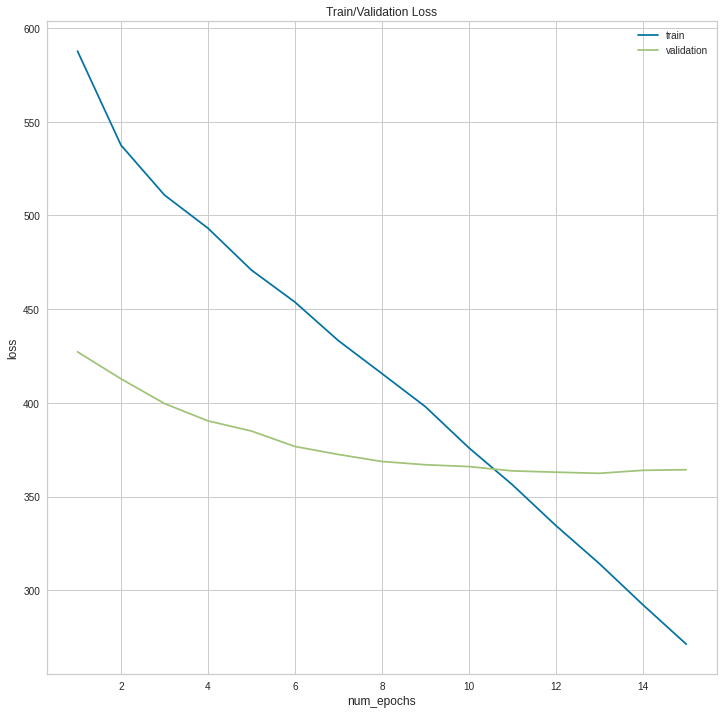

In [ ]:
plot_graph(n_epochs)
#plot_graphs(history, "accuracy")

/usr/local/lib/python3.7/dist-packages/scikitplot/plotters.py:37: DeprecationWarning: This module was deprecated in version 0.3.0 and its functions are spread throughout different modules. Please check the documentation and update your function calls as soon as possible. This module will be removed in 0.4.0
  DeprecationWarning)


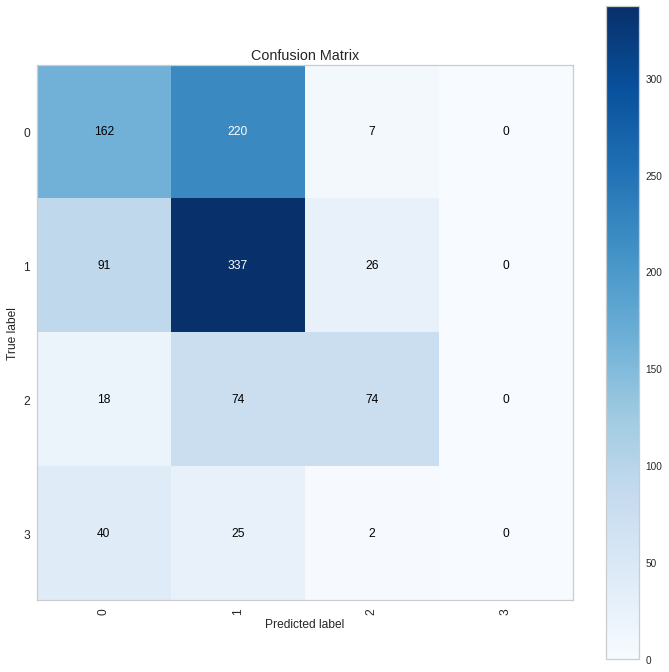

In [ ]:
!pip install scikit-plot
import scikitplot as skplt
y_true = [le.classes_[x] for x in val_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

### Base Model Evaluation:

In [ ]:
def predict_single(x):    
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [ ]:
L = []
for items in test_X.iteritems():
    a = predict_single(items[1])
    L.append(a)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [142]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score

a =pd.Series(L)
cm = confusion_matrix(test_Y, a)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


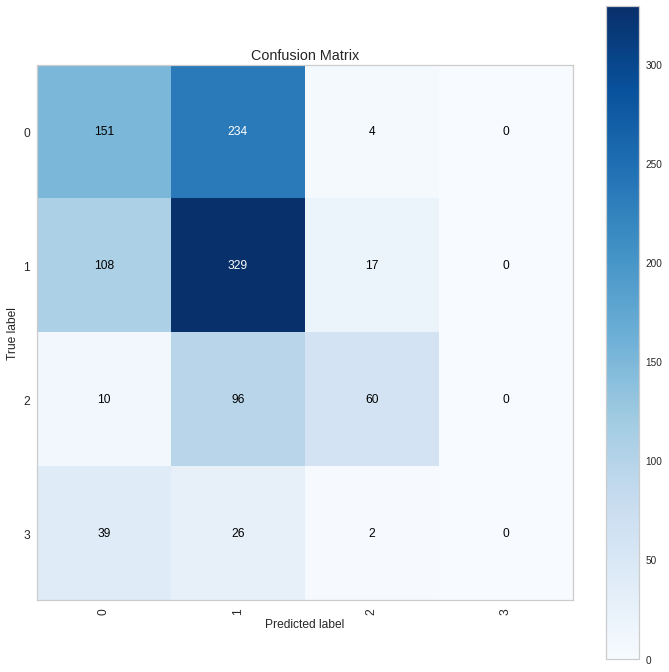

In [ ]:
skplt.metrics.plot_confusion_matrix(
    test_Y, 
    a,
    figsize=(12,12),x_tick_rotation=90)

In [ ]:
metrics.cohen_kappa_score(a, test_Y, labels=None, weights=None, sample_weight=None)

0.19133590205217077

### Metrics:

In [141]:
from termcolor import cprint, colored as c

def inc(d, label):
    if label in d:
        d[label] += 1
    else:
        d[label] = 1

def precision_recall(output, target):
    assert len(output) == len(target), "output len: {} != target len: {}".format(len(output), len(target))
    labels = set(target)
    TP = {}
    TP_plus_FN = {}
    TP_plus_FP = {}
    for i in range(len(output)):

        inc(TP_plus_FN, target[i])
        inc(TP_plus_FP, output[i])
        if target[i] == output[i]:
            inc(TP, output[i])

    for label in labels:
        if label not in TP_plus_FN:
            TP_plus_FN[label] = 0
        if label not in TP_plus_FP:
            TP_plus_FP[label] = 0

    precision = {label: 0. if TP_plus_FP[label] ==0 else ((TP[label] if label in TP else 0) / float(TP_plus_FP[label])) for label in labels}
    recall = {label: 0. if TP_plus_FN[label] ==0 else ((TP[label] if label in TP else 0) / float(TP_plus_FN[label])) for label in labels}

    return precision, recall, TP, TP_plus_FN, TP_plus_FP


def F_score(p, r):

    f_scores = {
        label: None if p[label] == 0 and r[label] == 0 else (0 if p[label] == 0 or r[label] == 0 else 2 / (1 / p[label] + 1 / r[label]))
        for label in p
    }
    return f_scores


def print_f_score(output, target):
    """returns: 
        p<recision>, 
        r<ecall>, 
        f<-score>, 
        {"TP", "p", "TP_plus_FP"} """
    p, r, TP, TP_plus_FN, TP_plus_FP = precision_recall(output, target)
    f = F_score(p, r)

    # cprint("Label: " + c(("  " + str(10))[-5:], 'red') +
    #            "\tPrec: " + c("  {:.1f}".format(0.335448 * 100)[-5:], 'green') + '%' +
    #            " ({:d}/{:d})".format(1025, 1254).ljust(14) +
    #            "Recall: " + c("  {:.1f}".format(0.964 * 100)[-5:], 'green') + "%" +
    #            " ({:d}/{:d})".format(15, 154).ljust(14) +
    #            "F-Score: " +  (c("  {:.1f}".format(0.5 * 100)[-5:], "green") + "%")
    #            )

    for label in f.keys():
        cprint("Label: " + c(("  " + str(label))[-5:], 'red') +
               "\tPrec: " + c("  {:.1f}".format(p[label] * 100)[-5:], 'green') + '%' +
               " ({:d}/{:d})".format((TP[label] if label in TP else 0), TP_plus_FP[label]).ljust(14) +
               "Recall: " + c("  {:.1f}".format((r[label] if label in r else 0) * 100)[-5:], 'green') + "%" +
               " ({:d}/{:d})".format((TP[label] if label in TP else 0), TP_plus_FN[label]).ljust(14) +
               "F-Score: " + ("  N/A" if f[label] is None else (c("  {:.1f}".format(f[label] * 100)[-5:], "green") + "%"))
               )
    # return p, r, f, _


if __name__ == '__main__':

    import torch
    import torch.autograd as autograd
    output = L
    output = torch.LongTensor(output)
    # target = [0,0,2,1,2,2,1,2,1,2,0]

    target = test_Y.tolist()

    target = torch.LongTensor(target)
    output = autograd.Variable(output)
    target = autograd.Variable(target)
    print('output')
    print(output.data.numpy().tolist())
    print('target')
    print(target.data.numpy().tolist())

    
    precision, recall, TP, TP_plus_FN, TP_plus_FP = precision_recall(output.data.numpy().tolist(), target.data.numpy().tolist())
    print('precision')
    print(precision)
    print('recall')
    print(recall)
    print('TP')
    print(TP)
    print('TP_plus_FN')
    print(TP_plus_FN)
    print('TP_plus_FP')
    print(TP_plus_FP)
    # print(dic)


    f_scores = F_score(precision, recall)
    print('f_scores')
    print(f_scores)
    # print(f_scores.keys())

    
    print('\r')
    print_f_score(output.data.numpy().tolist(), target.data.numpy().tolist())

output
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 2, 0, 1, 1, 2, 0, 1, 0, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 0, 1, 1, 0, 0,

Other metrics than can be considered are Precision Recall Curve and ROC Curve